# Couple Cluster Calculations with Recurrent Neural Networks

The following code provides an example of how recurrent neural networks can be used to extrapolate to unknown values of physics data sets.  Specifically, the data sets used in this program come from couple cluster analysis of the pairing model.

## Imports

The main imports used in this program come from the library Keras, which is an easy to use front end for the machine learning library Tensorflow.

In [1]:
# For matrices and calculations
import numpy as np
# For machine learning (backend for keras)
import tensorflow as tf
# User-friendly machine learning library
# Front end for TensorFlow
import keras
# Different methods from Keras needed to create an RNN
# This is not necessary but it shortened function calls 
# that need to be used in the code.
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Activation 
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
# For timing the code
from timeit import default_timer as timer
# For plotting
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Data Sets

The following three data sets were generated using a coupled clusters double code applied to the pairing model.  For all three data sets, datatype is a name that is used for saving data later in the program, X_tot is the x data, and y_tot is the y data.

* Vary Dimension: Generated by fixing the strength of the interaction, g, but varying the number of particle/hole states.  The x data are the number of particle/hole states and the y data are the couple cluster doubles correlation energies.
* Vary Interaction Positive/Negative: Generating by fixing the number of particle/hole states and varying the interaction strength, g.  The x data are interaction strengths and the y data are the couple cluster doubles correlation energies.

Uncomment only one data set at a time to use with the below reurrent neural network.  VaryDimension and VaryInteractionNegative work the best due to irregularities in VaryInteractionPositive and higher values of g.

Note that these data sets are small (very tiny in a machine learning sense), but meaningful and accurate results can still be obtained by applying machine learning to this data.

In [2]:
# Vary Dimension
datatype='VaryDimension'
X_tot = np.arange(2, 42, 2)
y_tot = np.array([-0.03077640549, -0.08336233266, -0.1446729567, -0.2116753732, -0.2830637392, -0.3581341341, -0.436462435, -0.5177783846,
	-0.6019067271, -0.6887363571, -0.7782028952, -0.8702784034, -0.9649652536, -1.062292565, -1.16231451, 
	-1.265109911, -1.370782966, -1.479465113, -1.591317992, -1.70653767])

# Vary Interaction Negative
#datatype='VaryDimensionNegative'
#X_tot = np.arange(-1, 0, 0.05)
#y_tot = np.array([-1.019822621,-0.9373428759,-0.8571531335,-0.7793624503,-0.7040887974,
#    -0.6314601306,-0.561615627,-0.4947071038,-0.4309007163,-0.3703789126,-0.3133427645,
#    -0.2600147228,-0.2106419338,-0.1655002064,-0.1248988336,-0.08918647296,-0.05875839719,
#    -0.03406548992,-0.01562553455,-0.004037522178])


# Vary Interaction Positive
#datatype ='VaryDimensionPositive'
#X_tot = np.arange(0.05, 0.85, 0.05)
#y_tot = np.array([-0.004334904077,-0.01801896484,-0.04222576507,-0.07838310563,-0.128252924,
#    -0.1940453966,-0.2785866456,-0.3855739487,-0.5199809785,-0.6887363571,-0.9019400869,-1.175251697,
#    -1.535217909,-2.033720441,-2.80365727,-4.719209688])


## Formatting the Data

The way the recurrent neural networks are trained in this program differs from how machine learning algorithms are usually trained.  Typically a machine learning algorithm is trained by learning the relationship between the x data and the y data.  In this program, the recurrent neural network will be trained to recognize the relationship in a sequence of y values.  This is type of data formatting is typically used time series forcasting, but it can also be used in any extrapolation (time series forecasting is just a specific type of extrapolation along the time axis).  This method of data formatting does not use the x data and assumes that the y data are evenly spaced.

For a standard machine learning algorithm, the training data has the form of (x,y) so the machine learning algorithm learns to assiciate a y value with a given x value.  This is useful when the test data has x values within the same range as the training data.  However, for this application, the x values of the test data are outside of the x values of the training data and the traditional method of training a machine learning algorithm does not work as well.  For this reason, the recurrent neural network is trained on sequences of y values of the form ((y1, y2), y3), so that the network is concerned with learning the pattern of the y data and not the relation between the x and y data.  As long as the pattern of y data outside of the training region stays relatively stable compared to what was inside the training region, this method of training can produce accurate extrapolations to y values far removed from the training data set.

The idea behind formatting the data in this way comes from [this resource](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) and [this one](https://fairyonice.github.io/Understand-Keras%27s-RNN-behind-the-scenes-with-a-sin-wave-example.html).

The following method takes in a y data set and formats it so the "x data" are of the form (y1, y2) and the "y data" are of the form y3, with extra brackets added in to make the resulting arrays compatable with both Keras and Tensorflow.

Note: Using a sequence length of two is not required for time series forecasting so any lenght of sequence could be used (for example instead of ((y1, y2) y3) you could change the length of sequence to be 4 and the resulting data points would have the form ((y1, y2, y3, y4), y5)).  While the following method can be used to create a data set of any sequence length, the remainder of the code expects the length of sequence to be 2.  This is because the data sets are very small and the higher the lenght of the sequence the less resulting data points.

In [3]:
# FORMAT_DATA
def format_data(data, length_of_sequence = 2):  
    """
        Inputs:
            data(a numpy array): the data that will be the inputs to the recurrent neural
                network
            length_of_sequence (an int): the number of elements in one iteration of the
                sequence patter.  For a function approximator use length_of_sequence = 2.
        Returns:
            rnn_input (a 3D numpy array): the input data for the recurrent neural network.  Its
                dimensions are length of data - length of sequence, length of sequence, 
                dimnsion of data
            rnn_output (a numpy array): the training data for the neural network
        Formats data to be used in a recurrent neural network.
    """

    X, Y = [], []
    for i in range(len(data)-length_of_sequence):
        # Get the next length_of_sequence elements
        a = data[i:i+length_of_sequence]
        # Get the element that immediately follows that
        b = data[i+length_of_sequence]
        # Reshape so that each data point is contained in its own array
        a = np.reshape (a, (len(a), 1))
        X.append(a)
        Y.append(b)
    rnn_input = np.array(X)
    rnn_output = np.array(Y)

    return rnn_input, rnn_output


## Defining the Recurrent Neural Network Using Keras

The following method defines a simple recurrent neural network in keras consisting of one input layer, one hidden layer, and one output layer.

In [4]:
def rnn(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with one hidden layer and returns the model.
    """
    # Number of neurons in the input and output layers
    in_out_neurons = 1
    # Number of neurons in the hidden layer
    hidden_neurons = 200
    # Define the input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  
    # Define the hidden layer as a simple RNN layer with a set number of neurons and add it to 
    # the network immediately after the input layer
    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN")(inp)
    # Define the output layer as a dense neural network layer (standard neural network layer)
    #and add it to the network immediately after the hidden layer.
    dens = Dense(in_out_neurons,name="dense")(rnn)
    # Create the machine learning model starting with the input layer and ending with the 
    # output layer
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the machine learning model using the mean squared error function as the loss 
    # function and an Adams optimizer.
    model.compile(loss="mean_squared_error", optimizer="adam")  
    return model

# Predicting New Points With A Trained Recurrent Neural Network

This is needed because each new predicted points gets formatted and used to predict the next point in the series.  Also includes a small data anlysis and graphing code.

In [5]:
def test_rnn (x1, y_test, plot_min, plot_max):
    """
        Inputs:
            x1 (a list or numpy array): The complete x component of the data set
            y_test (a list or numpy array): The complete y component of the data set
            plot_min (an int or float): the smallest x value used in the training data
            plot_max (an int or float): the largest x valye used in the training data
        Returns:
            None.
        Uses a trained recurrent neural network model to predict future points in the 
        series.  Computes the MSE of the predicted data set from the true data set, saves
        the predicted data set to a csv file, and plots the predicted and true data sets w
        while also displaying the data range used for training.
    """
    # Add the training data as the first dim points in the predicted data array as these
    # are known values.
    y_pred = y_test[:dim].tolist()
    # Generate the first input to the trained recurrent neural network using the last two 
    # points of the training data.  Based on how the network was trained this means that it
    # will predict the first point in the data set after the training data.  All of the 
    # brackets are necessary for Tensorflow.
    next_input = np.array([[[y_test[dim-2]], [y_test[dim-1]]]])
    # Save the very last point in the training data set.  This will be used later.
    last = [y_test[dim-1]]

    # Iterate until the complete data set is created.
    for i in range (dim, len(y_test)):
        # Predict the next point in the data set using the previous two points.
        next = model.predict(next_input)
        # Append just the number of the predicted data set
        y_pred.append(next[0][0])
        # Create the input that will be used to predict the next data point in the data set.
        next_input = np.array([[last, next[0]]], dtype=np.float64)
        last = next

    # Print the mean squared error between the known data set and the predicted data set.
    print('MSE: ', np.square(np.subtract(y_test, y_pred)).mean())
    # Save the predicted data set as a csv file for later use
    name = datatype + 'Predicted'+str(dim)+'.csv'
    np.savetxt(name, y_pred, delimiter=',')
    # Plot the known data set and the predicted data set.  The red box represents the region that was used
    # for the training data.
    fig, ax = plt.subplots()
    ax.plot(x1, y_test, label="true", linewidth=3)
    ax.plot(x1, y_pred, 'g-.',label="predicted", linewidth=4)
    ax.legend()
    # Created a red region to represent the points used in the training data.
    ax.axvspan(plot_min, plot_max, alpha=0.25, color='red')
    plt.show()

# Running the Code

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 1)]            0         
_________________________________________________________________
RNN (SimpleRNN)              (None, 200)               40400     
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 40,601
Trainable params: 40,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
1/1 [==============================] - 0s 223ms/step - loss: 0.2455 - val_loss: 0.3452
Epoch 2/150
1/1 [==============================] - 0s 22ms/step - loss: 0.1116 - val_loss: 0.0901
Epoch 3/150
1/1 [==============================] - 0s 22ms/step - loss: 0.0314 - val_loss: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 22ms/step - loss: 0.0011 - val_

1/1 [==============================] - 0s 20ms/step - loss: 2.1834e-05 - val_loss: 1.3003e-06
Epoch 74/150
1/1 [==============================] - 0s 21ms/step - loss: 1.1511e-05 - val_loss: 1.1914e-05
Epoch 75/150
1/1 [==============================] - 0s 19ms/step - loss: 1.5121e-05 - val_loss: 5.1258e-05
Epoch 76/150
1/1 [==============================] - 0s 22ms/step - loss: 2.7375e-05 - val_loss: 9.2522e-05
Epoch 77/150
1/1 [==============================] - 0s 21ms/step - loss: 4.0277e-05 - val_loss: 1.1324e-04
Epoch 78/150
1/1 [==============================] - 0s 21ms/step - loss: 4.7042e-05 - val_loss: 1.0450e-04
Epoch 79/150
1/1 [==============================] - 0s 21ms/step - loss: 4.4831e-05 - val_loss: 7.2735e-05
Epoch 80/150
1/1 [==============================] - 0s 20ms/step - loss: 3.5327e-05 - val_loss: 3.4367e-05
Epoch 81/150
1/1 [==============================] - 0s 18ms/step - loss: 2.3229e-05 - val_loss: 6.8621e-06
Epoch 82/150
1/1 [==============================] 

1/1 [==============================] - 0s 25ms/step - loss: 9.0619e-06 - val_loss: 5.9421e-06
Epoch 150/150
1/1 [==============================] - 0s 33ms/step - loss: 9.0700e-06 - val_loss: 6.0660e-06


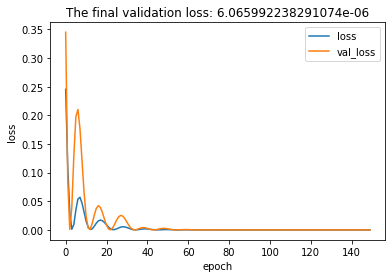

MSE:  0.0008915286079484311


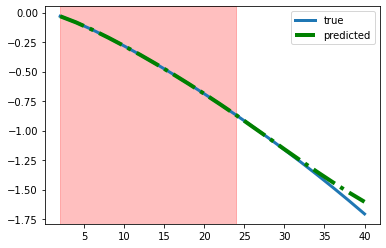

Time:  6.416914270000001


In [6]:
# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data(y_train, 2)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
model = rnn(length_of_sequences = rnn_input.shape[1])
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)


# This section plots the training loss and the validation loss as a function of training iteration.
# This is not required for analyzing the couple cluster data but can help determine if the network is
# being overtrained.
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict more points of the data set
test_rnn(X_tot, y_tot, X_tot[0], X_tot[dim-1])
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

## Other Things to Try

### Vary the Network Parameters and the Size of the Network

Changing the size of the recurrent neural network and its parameters can drastically change the results you get from the model.  The below code takes the simple recurrent neural network from above and adds a second hidden layer, changes the number of neurons in the hidden layer, and explicitly declares the activation function of the hidden layers to be a sigmoid function.  The loss function and optimizer can also be changed but are kept the same as the above network.  These parameters can be tuned to provide the optimal result from the network.  For some ideas on how to improve the performance of a recurrent neural network see [this link](https://danijar.com/tips-for-training-recurrent-neural-networks/).

In [7]:
def rnn_2layers(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with two hidden layers and returns the model.
    """
    # Number of neurons in the input and output layers
    in_out_neurons = 1
    # Number of neurons in the hidden layer, increased from the first network
    hidden_neurons = 500
    # Define the input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  
    # Create two hidden layers instead of one hidden layer.  Explicitly set the activation
    # function to be the sigmoid function (the default value is hyperbolic tangent)
    rnn1 = SimpleRNN(hidden_neurons, 
                    return_sequences=True,  # This needs to be True if another hidden layer is to follow
                    stateful = stateful, activation = 'sigmoid',
                    name="RNN1")(inp)
    rnn2 = SimpleRNN(hidden_neurons, 
                    return_sequences=False, activation = 'sigmoid',
                    stateful = stateful,
                    name="RNN2")(rnn1)
    # Define the output layer as a dense neural network layer (standard neural network layer)
    #and add it to the network immediately after the hidden layer.
    dens = Dense(in_out_neurons,name="dense")(rnn2)
    # Create the machine learning model starting with the input layer and ending with the 
    # output layer
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the machine learning model using the mean squared error function as the loss 
    # function and an Adams optimizer.
    model.compile(loss="mean_squared_error", optimizer="adam")  
    return model

This re-runs the program using the new neural network.

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2, 1)]            0         
_________________________________________________________________
RNN1 (SimpleRNN)             (None, 2, 500)            251000    
_________________________________________________________________
RNN2 (SimpleRNN)             (None, 500)               500500    
_________________________________________________________________
dense (Dense)                (None, 1)                 501       
Total params: 752,001
Trainable params: 752,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
1/1 [==============================] - 0s 330ms/step - loss: 0.0431 - val_loss: 10.4730
Epoch 2/150
1/1 [==============================] - 0s 25ms/step - loss: 13.4338 - val_loss: 0.2692
Epoch 3/150
1/1 [==============================

Epoch 75/150
1/1 [==============================] - 0s 30ms/step - loss: 0.0446 - val_loss: 0.1384
Epoch 76/150
1/1 [==============================] - 0s 26ms/step - loss: 0.0442 - val_loss: 0.1473
Epoch 77/150
1/1 [==============================] - 0s 28ms/step - loss: 0.0432 - val_loss: 0.1608
Epoch 78/150
1/1 [==============================] - 0s 63ms/step - loss: 0.0421 - val_loss: 0.1766
Epoch 79/150
1/1 [==============================] - 0s 22ms/step - loss: 0.0417 - val_loss: 0.1917
Epoch 80/150
1/1 [==============================] - 0s 23ms/step - loss: 0.0420 - val_loss: 0.2033
Epoch 81/150
1/1 [==============================] - 0s 23ms/step - loss: 0.0426 - val_loss: 0.2093
Epoch 82/150
1/1 [==============================] - 0s 23ms/step - loss: 0.0430 - val_loss: 0.2089
Epoch 83/150
1/1 [==============================] - 0s 27ms/step - loss: 0.0430 - val_loss: 0.2028
Epoch 84/150
1/1 [==============================] - 0s 20ms/step - loss: 0.0425 - val_loss: 0.1927
Epoch 85/1

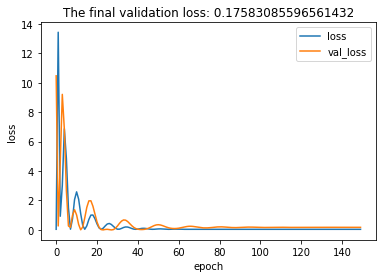

MSE:  0.3314148744262398


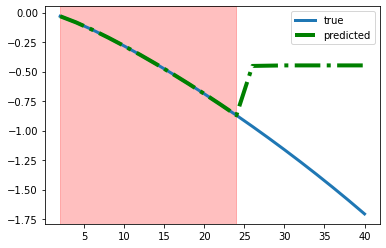

Time:  7.952526589999998


In [8]:
# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data(y_train, 2)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
model = rnn_2layers(length_of_sequences = 2)
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)


# This section plots the training loss and the validation loss as a function of training iteration.
# This is not required for analyzing the couple cluster data but can help determine if the network is
# being overtrained.
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict more points of the data set
test_rnn(X_tot, y_tot, X_tot[0], X_tot[dim-1])
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

### Other Types of Recurrent Neural Networks

Besides a simple recurrent neural network layer, there are two other commonly used types of recurrent neural network layers: Long Short Term Memory (LSTM) and Gated Recurrent Unit (GRU).  For a short introduction to these layers see [this](https://medium.com/mindboard/lstm-vs-gru-experimental-comparison-955820c21e8b) and [this](https://medium.com/mindboard/lstm-vs-gru-experimental-comparison-955820c21e8b).  The first network created below is similar to the previous network, but it replaces the SimpleRNN layers with LSTM layers.  The second network below has two hidden layers made up of GRUs, which are preceeded by two dense (feeddorward) neural network layers.  These dense layers "preprocess" the data before it reaches the recurrent layers.  This architecture has been shown to improve the performance of recurrent neural networks (see the link above and also [here](https://arxiv.org/pdf/1807.02857.pdf)

In [11]:
def lstm_2layers(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with two LSTM hidden layers and returns the model.
    """
    # Number of neurons on the input/output layer and the number of neurons in the hidden layer
    in_out_neurons = 1
    hidden_neurons = 250
    # Input Layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons)) 
    # Hidden layers (in this case they are LSTM layers instead if SimpleRNN layers)
    rnn= LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful = stateful,
                    name="RNN", use_bias=True, activation='tanh')(inp)
    rnn1 = LSTM(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN1", use_bias=True, activation='tanh')(rnn)
    # Output layer
    dens = Dense(in_out_neurons,name="dense")(rnn1)
    # Define the midel
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')  
    # Return the model
    return model


In [12]:
def dnn2_gru2(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with four hidden layers (two dense followed by
        two GRU layers) and returns the model.
    """    
    # Number of neurons on the input/output layers and hidden layers
    in_out_neurons = 1
    hidden_neurons = 250
    # Input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons)) 
    # Hidden Dense (feedforward) layers
    dnn = Dense(hidden_neurons/2, activation='relu', name='dnn')(inp)
    dnn1 = Dense(hidden_neurons/2, activation='relu', name='dnn1')(dnn)
    # Hidden GRU layers
    rnn1 = GRU(hidden_neurons, 
                    return_sequences=True,
                    stateful = stateful,
                    name="RNN1", use_bias=True)(dnn1)
    rnn = GRU(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN", use_bias=True)(rnn1)
    # Output layer
    dens = Dense(in_out_neurons,name="dense")(rnn)
    # Define the model
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the mdoel
    model.compile(loss='mean_squared_error', optimizer='adam')  
    # Return the model
    return model

Model: "functional_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 2, 1)]            0         
_________________________________________________________________
dnn (Dense)                  (None, 2, 125)            250       
_________________________________________________________________
dnn1 (Dense)                 (None, 2, 125)            15750     
_________________________________________________________________
RNN1 (GRU)                   (None, 2, 250)            282750    
_________________________________________________________________
RNN (GRU)                    (None, 250)               376500    
_________________________________________________________________
dense (Dense)                (None, 1)                 251       
Total params: 675,501
Trainable params: 675,501
Non-trainable params: 0
_______________________________________________

1/1 [==============================] - 0s 19ms/step - loss: 4.9758e-06 - val_loss: 1.1676e-06
Epoch 146/150
1/1 [==============================] - 0s 19ms/step - loss: 4.8802e-06 - val_loss: 1.0256e-06
Epoch 147/150
1/1 [==============================] - 0s 18ms/step - loss: 4.7743e-06 - val_loss: 7.5709e-07
Epoch 148/150
1/1 [==============================] - 0s 19ms/step - loss: 4.6600e-06 - val_loss: 4.7337e-07
Epoch 149/150
1/1 [==============================] - 0s 19ms/step - loss: 4.5519e-06 - val_loss: 2.6288e-07
Epoch 150/150
1/1 [==============================] - 0s 19ms/step - loss: 4.4585e-06 - val_loss: 1.4872e-07


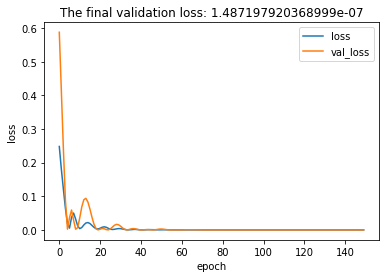

MSE:  0.0002961885629100235


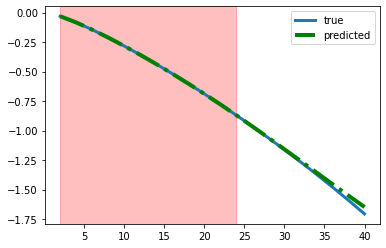

Time:  9.24558208999224


In [70]:
# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data(y_train, 2)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
# Change the method name to reflect which network you want to use
model = dnn2_gru2(length_of_sequences = 2)
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)


# This section plots the training loss and the validation loss as a function of training iteration.
# This is not required for analyzing the couple cluster data but can help determine if the network is
# being overtrained.
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict more points of the data set
test_rnn(X_tot, y_tot, X_tot[0], X_tot[dim-1])
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

### Training Recurrent Neural Networks in the Standard Way (i.e. learning the relationship between the X and Y data)

Finally, comparing the performace of a recurrent neural network using the standard data formatting to the performance of the network with time sequence data formatting shows the benefit of this type of data formatting with extrapolation.

Model: "functional_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 1, 1)]            0         
_________________________________________________________________
RNN (SimpleRNN)              (None, 200)               40400     
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 40,601
Trainable params: 40,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
1/1 [==============================] - 0s 149ms/step - loss: 2.0112 - val_loss: 2.9160
Epoch 2/150
1/1 [==============================] - 0s 18ms/step - loss: 1.4488 - val_loss: 2.1054
Epoch 3/150
1/1 [==============================] - 0s 17ms/step - loss: 0.9830 - val_loss: 1.4369
Epoch 4/150
1/1 [==============================] - 0s 19ms/step - loss: 0.6141 - val

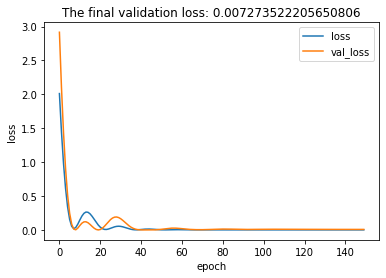

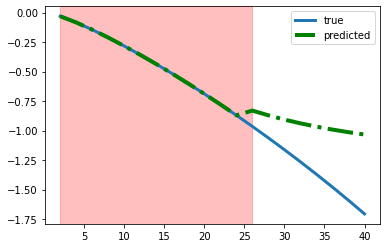

Time:  4.735089802998118


In [71]:
# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]

# Reshape the data for Keras specifications
X_train = X_train.reshape((dim, 1))
y_train = y_train.reshape((dim, 1))


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
# Set the sequence length to 1 for regular data formatting 
model = rnn(length_of_sequences = 1)
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(X_train, y_train, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)


# This section plots the training loss and the validation loss as a function of training iteration.
# This is not required for analyzing the couple cluster data but can help determine if the network is
# being overtrained.
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict the remaining data points
X_pred = X_tot[dim:]
X_pred = X_pred.reshape((len(X_pred), 1))
y_model = model.predict(X_pred)
y_pred = np.concatenate((y_tot[:dim], y_model.flatten()))

# Plot the known data set and the predicted data set.  The red box represents the region that was used
# for the training data.
fig, ax = plt.subplots()
ax.plot(X_tot, y_tot, label="true", linewidth=3)
ax.plot(X_tot, y_pred, 'g-.',label="predicted", linewidth=4)
ax.legend()
# Created a red region to represent the points used in the training data.
ax.axvspan(X_tot[0], X_tot[dim], alpha=0.25, color='red')
plt.show()

# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)